In [95]:
import Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`


In [96]:
using ControlSystemsBase
using LinearAlgebra
using Plots
import ForwardDiff as FD

In [97]:
# actual non linear continous dynamics of the simple pendulum

# simple pendulum paramters

m=1    # mass is of the pendulum
g=9.81 # gravity
l=1 # length of the pendulum

h=0.001 # time step for rk45 integrator

# actual dynamics
function dynamics(x,τ)
     x1,x2 =x
     x1_dot= x2
     x2_dot= -(g / l)*sin(x1)+(τ / (m*l^2))
    return [x1_dot;x2_dot]
end

#use RK45 integrator with zero order hold control
function rk45step(x,τ)
   f1=dynamics(x,τ)
   f2=dynamics(x+0.5*h*f1,τ)
   f3=dynamics(x+0.5*h*f2,τ)
   f4=dynamics(x+h*f3,τ)
    
   return x+(h/6)*(f1+2*f2+2*f3+f4)   
end


rk45step (generic function with 1 method)

In [98]:
# dynamics of the simple pendulum after feedback linearization
# it will be reduced to θ̈=u and τ=mglsin(θ)+ml²u

#state matrix and control matrix of the feedback linearized model
A_f=[0 1; 0 0]
B_f=[0;1]

#find the discrete state space of above feedback linearized model
#nx=2 #number of state
#nu=1 #number of control input
#H = exp([A_f B_f; zeros(nu, nx + nu)]*h)
#Ad = H[1:nx,1:nx] 
#Bd = H[1:nx,(nx+1):(nx+nu)]

Ad=[1.0 0.001; 0.0 1.0]
Bd=[0;0.001]

2-element Vector{Float64}:
 0.0
 0.001

In [128]:
#design the LQR for the feedback linerized discrete model
Q=diagm([4200,60])
R=5
K=lqr(Discrete,Ad,Bd,Q,R) #calculated the gain by using the inbuilt lqr function


1×2 Matrix{Float64}:
 28.8618  8.35852

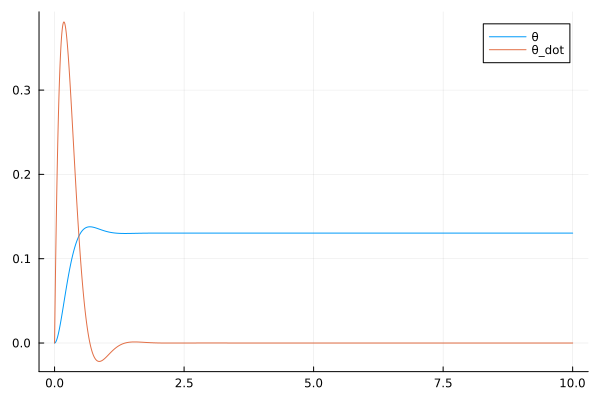

In [129]:
# move the pendulum to position of [pi/2,0] from [0,0]
x0=[0,0]
xref=[pi/18,0]

#problem size
tf=10
t_vec=0:h:tf
N=length(t_vec)

#states 
X=[zeros(nx) for i=1:N]
X[1]=x0

#error vector
E=[zeros(nx) for i=1:N]

E[1]=[0,0]

T=[zeros(nu) for i=1:N]
T[1]=[0]


for i = 1:N-1
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        e=(X[i]-xref)
        E[i+1]=e
        u_lqr = -K*e
        # adjust the input to cancel the non linear part of the dynamics
        τ= m*g*l*sin(X[1][1])+m*l*l*u_lqr[1]
        T[i+1]=[τ]
        #feedback linearized
        X[i+1]=rk45step(X[i],τ)
      
end
    
Xm = hcat(X...)
Em= hcat(E...)
Tm= hcat(T...)



plot(t_vec,Xm[1,:],label="θ")
plot!(t_vec,Xm[2,:],label="θ_dot")



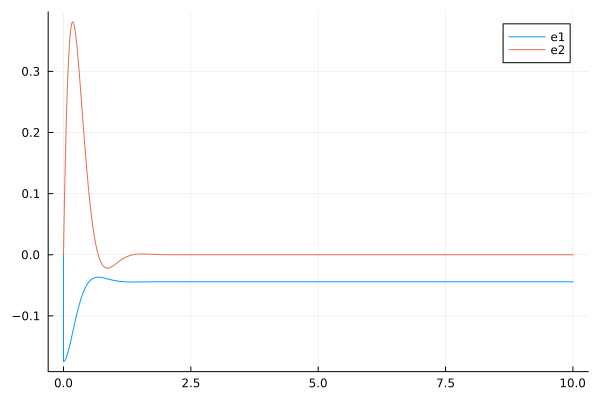

In [130]:
plot(t_vec,Em[1,:],label="e1")
plot!(t_vec,Em[2,:],label="e2")



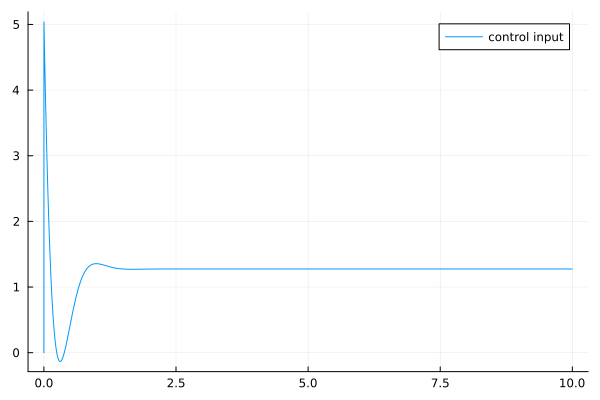

In [131]:
plot(t_vec,Tm[1,:],label="control input")